# COMP90051 Project 2

In [30]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implement ε-Greedy and UCB

In [31]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [53]:
def index_max(input_list):
    """
    return the index of the max element in the list.
    NOTICE: Tie-breaking uniformly among value-maximising arms.
    """
    m = max(input_list)
    index_list = [i for i, j in enumerate(input_list) if j == m]
    if len(index_list) == 1:
        return index_list[0]
    else:
        return np.random.choice(index_list)

In [64]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        self.narms=narms
        self.epsilon=epsilon
        # 记录每一个arm的次数和reward
        self.counts = [0 for col in range(self.narms)]
        self.avg_rewards = [Q0 for col in range(self.narms)]
        
    def play(self, tround, context=None):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
        # exploit
        if np.random.random() > self.epsilon:
            return index_max(self.avg_rewards)
        else:
        # explore
            return np.random.randint(self.narms)
        
    def update(self, arm, reward, context=None):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """
        self.counts[arm] = self.counts[arm] + 1
        n = self.counts[arm]
        old_avg_reward = self.avg_rewards[arm]
        if self.avg_rewards[arm] == np.inf:
            new_avg_reward = reward
        else:
            new_avg_reward = (old_avg_reward * (n-1) + reward)/n
        self.avg_rewards[arm] = new_avg_reward

In [233]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        self.narms = narms
        self.rho = rho
        # 记录每一个arm的次数和reward
        self.counts = [0 for col in range(self.narms)]
        self.avg_rewards = [Q0 for col in range(self.narms)]
        
    def play(self, tround, context=None):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
        # tround is used for UCB
        ucb_values = [0.0 for arm in range(self.narms)]
        for arm in range(self.narms):
            # print(float(self.counts[arm]))
            # todo 这里其他人怎么处理
            if self.counts[arm] ==0:
                bonus = 0
            else:
                bonus = np.sqrt((self.rho*np.log(tround))/float(self.counts[arm]))
            # 是使得当前tround下达到最大的，和update不一样，update是选完arm后的action.
            ucb_values[arm] = self.avg_rewards[arm] + bonus
#             print(ucb_values[arm])
        return index_max(ucb_values)
        
        
    def update(self, arm, reward, context=None):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """
        self.counts[arm] = self.counts[arm] + 1
        n = self.counts[arm]
        old_avg_reward = self.avg_rewards[arm]
        if self.avg_rewards[arm] == np.inf:
            new_avg_reward = reward
        else:
            new_avg_reward = (old_avg_reward * (n-1) + reward)/n
        self.avg_rewards[arm] = new_avg_reward

## 2. Off-Policy Evaluation

In [332]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    rewards_for_matched_round = []
    count_round = 1
    length = len(rewards)
    for tround in range(length):
        # tround是从0开始的
        # end
       
        # pull/play 一次
        context = contexts[tround]
        response_arm = arms[tround]
        response_reward = rewards[tround]
        # todo 是否需要的是下一轮的?
        estimate_arm = mab.play(count_round, context)
        if estimate_arm == response_arm:
            count_round += 1
            rewards_for_matched_round.append(response_reward)
            # update
            mab.update(response_arm, response_reward, context)
        if count_round > nrounds:
            break
    return rewards_for_matched_round

In [157]:
# load the data
dataset = np.loadtxt('dataset.txt', dtype=int)
arms = dataset[:,0]
rewards = dataset[:,1]
contexts = dataset[:,2:102]

In [296]:
import pandas as pd
df = pd.DataFrame(dataset)
df.groupby(1).count()

,0,2,3,4,5,6,7,8,9,10,...,92,93,94,95,96,97,98,99,100,101
1,,,,,,,,,,,,,,,,,,,,,
0,8961,8961,8961,8961,8961,8961,8961,8961,8961,8961,...,8961,8961,8961,8961,8961,8961,8961,8961,8961,8961
1,1039,1039,1039,1039,1039,1039,1039,1039,1039,1039,...,1039,1039,1039,1039,1039,1039,1039,1039,1039,1039


In [345]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.10638297872340426


In [350]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.1111111111111111


## 3. Contextual Bandits

In [265]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        self.narms = narms
        self.ndims = ndims
        self.alpha = alpha
        self.A_list = [np.identity(ndims) for col in range(self.narms)]
        self.b_list = [np.zeros((ndims, 1)) for col in range(self.narms)]

    def play(self, tround, context=None):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
        p_ta_list = [0.0 for col in range(self.narms)]
        for arm in range(self.narms):
            context_arm = context[arm*10:(arm+1)*10]
            x_ta = np.array(context_arm).reshape(self.ndims,1)
            theta_a = np.dot(inv(self.A_list[arm]), self.b_list[arm])
            p_ta = np.dot(theta_a.T, x_ta) + self.alpha*np.sqrt(np.dot(np.dot(x_ta.T, inv(self.A_list[arm])), x_ta))
            p_ta_list[arm] = p_ta[0]
        return index_max(p_ta_list)
        
    def update(self, arm, reward, context=None):
        """
        Updates the internal state of the MAB after a play
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """
        old_A_value = np.array((self.A_list[arm]))
        old_b_value = np.array((self.b_list[arm]))
        context_arm = context[arm*10:(arm+1)*10]
        x_ta = np.array(context_arm).reshape(self.ndims,1)    
        self.A_list[arm] = old_A_value + np.dot(x_ta,x_ta.T)
        self.b_list[arm] = old_b_value + reward * x_ta
    

In [299]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.02702702702702703


## 4. Evaluation
### 4.A.

In [ ]:
number_of_trails = np.linspace(1, 800, 800)

In [376]:
result_mab_eps = []
for number_of_trail in number_of_trails:
    mab_eps = EpsGreedy(10, 0.05)
    result_rewards_per_trail = offlineEvaluate(mab_eps, arms, rewards, contexts, number_of_trail)
    result_mab_eps.append(np.mean(result_rewards_per_trail))

In [379]:
result_mab_ucb = []
for number_of_trail in number_of_trails:
    mab_ucb = UCB(10, 1.0)
    result_rewards_per_trail = offlineEvaluate(mab_ucb, arms, rewards, contexts, number_of_trail)
    result_mab_ucb.append(np.mean(result_rewards_per_trail))

In [381]:
result_mab_linucb = []
for number_of_trail in number_of_trails:
    mab_linucb = LinUCB(10, 10, 1.0)
    result_rewards_per_trail = offlineEvaluate(mab_linucb, arms, rewards, contexts, number_of_trail)
    result_mab_linucb.append(np.mean(result_rewards_per_trail))

### 4.B.

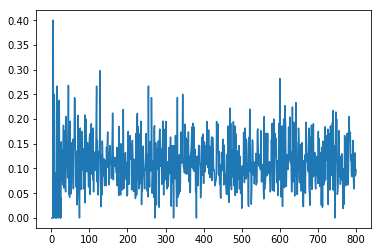

In [353]:
fig = plt.figure()
ax = plt.axes()
x = np.linspace(1, 800, 800)
# ax.plot(x, result_mab_eps);
ax.plot(x, result_mab_ucb);
ax.plot(x, result_mab_linucb);

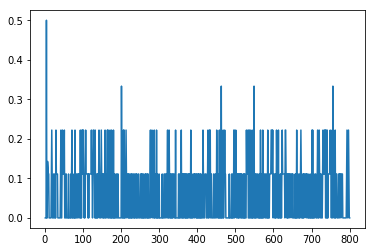

In [380]:
fig = plt.figure()
ax = plt.axes()
x = np.linspace(1, 800, 800)
ax.plot(x, result_mab_ucb);

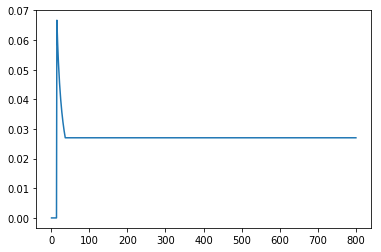

In [383]:
fig = plt.figure()
ax = plt.axes()
x = np.linspace(1, 800, 800)
ax.plot(x, result_mab_linucb);

## 5. KernelUCB

In [3]:
# Do not edit. Special import for this section.
from sklearn.metrics.pairwise import rbf_kernel

In [32]:
class KernelUCB(MAB):
    """
    Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    gamma : float
        positive real explore-exploit parameter
    
    eta : float
        positive real explore-exploit parameter
    
    kern : callable
        a kernel function from sklearn.metrics.pairwise
    """
    def __init__(self, narms, ndims, gamma, eta, kern):
        self.narms = narms
        self.ndims = ndims
        self.gamma = gamma
        self.eta = eta
        self.kern = kern
        self.u = [1] + [0]*(self.narms-1)
        self.y = list()
        self.xt_history = list()
        self.K_t_minus1_inverse = None
    
    def play(self, tround, context):
        # 返回argmax(u_t-1)
        return index_max(self.u)
    
    def update(self, arm, reward, context):
        # 继续做u_t的东西
        x_t = context[arm*10:(arm+1)*10]
        # length为t-1
        self.y.append(reward)
        # length为t了
        self.xt_history.append(x_t)
        y_t = np.array(self.y).reshape(-1,1)
        # t * 1 dimensional
        # 需要x_t, xt_history, tround
        # 注意xt_history得是tround * 1 的
        k_xt_t = np.array(list(map(lambda x,y:kern(x,y),[x_t]*tround, self.xt_history))).reshape(tround,1)
        
        if tround == 1:
            self.K_t_minus1_inverse = 1/(self.kern(x_t, x_t) + self.eta)
        else:
            # (tround - 1) * 1的
            b = np.array(list(map(lambda x,y:kern(x,y),[x_t]*tround, self.xt_history[:-1]))).reshape(tround-1,1)
            K_22 = 1/(self.kern(x_t, x_t) + self.eta - np.multi_dot(b.T, self.K_t_minus1_inverse, b))
            K_11 = self.K_t_minus1_inverse + np.multi_dot(K_22, self.K_t_minus1_inverse, b, b.T, self.K_t_minus1_inverse)
            K_12 = np.multi_dot(-K_22, self.K_t_minus1_inverse, b)
            K_21 = np.multi_dot(-K_22, b.T, self.K_t_minus1_inverse)
            K_t_inverse = np.block([[K_11, K_12],[K_21, K_22]])
        sigma_t = []
        u_t = []
        for arm in self.narms:
            x_nt = context[arm*10:(arm+1)*10].reshape(arms,-1)
            sigma_nt <- np.sqrt(self.kern(x_nt, x_nt) - np.multi_dot(k_xt_t.T, K_t_inverse, k_xt_t))
            sigma_t.append(sigma_nt)
            u_nt <- np.multi_dot(k_xt_t.T, K_t_inverse, y_t) + self.eta/sqrt(self.gamma) * sigma_nt
            u_t.append(u_nt)
        # 更新u_t
        self.u_t = u_t
        # 下一轮的
        self.K_t_minus1_inverse = K_t_inverse